# Apparel Recommendations usin Convolutional Neural Network

## Get the feature vectors of all apparel images

<pre>
   Running this cell will take time, you can skip running this cell. you can download the feature vectors from given link
   16k_data_cnn_features.npy: https://drive.google.com/open?id=0BwNkduBnePt2c1BkNzRDQ1dOVFk 
   bottleneck_features_cnn.npy : https://drive.google.com/open?id=0BwNkduBnePt2ODRxWHhUVzIyWDA
</pre>

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


In [2]:
#import all the necessary packages.

import PIL.Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

# load the extracted features

In [3]:
#function to create/read cnn features
if not os.path.isfile('16k_data_cnn_features.npy'):
    print('Running code to generate bottleneck features for our images')
    # dimensions of our images.
    img_width, img_height = 224, 224

    top_model_weights_path = 'bottleneck_fc_model.h5'
    train_data_dir = 'images2/'
    nb_train_samples = 16042
    epochs = 50
    batch_size = 1


    def save_bottlebeck_features():

        #Function to compute VGG-16 CNN for image feature extraction.

        asins = []
        datagen = ImageDataGenerator(rescale=1. / 255)

        # build the VGG16 network
        model = applications.VGG16(include_top=False, weights='imagenet')
        generator = datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)

        for i in generator.filenames:
            asins.append(i[2:-5])

        bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
        bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))

        np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
        np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))

    save_bottlebeck_features()
    bottleneck_features_train = np.load('16k_data_cnn_features.npy')
    asins = np.load('16k_data_cnn_feature_asins.npy')
    asins = list(asins)
    
else:
    
    bottleneck_features_train = np.load('16k_data_cnn_features.npy')
    asins = np.load('16k_data_cnn_feature_asins.npy')
    asins = list(asins)

In [4]:
#using the pickle file generated in out notebook AppliedAIWorkshop to read preprocessed data

data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')[:bottleneck_features_train.shape[0]]
df_asins = list(data['asin'])

In [5]:
# with GPU => per image 3.5/20 (0.175 sec), for whole data set its taking around 40min
# with CPU => per image 12.3/20 (0.615 sec), for whole data set its taking around 160min

In [6]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [7]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [8]:
#Functiom to genearte heatmap of images along with other details
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [9]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)

In [10]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

# credits: https://www.kaggle.com/c/word2vec-nlp-tutorial#part-2-word-vectors
# Custom Word2Vec using your own text data.
# Do NOT RUN this code.
# It is meant as a reference to build your own Word2Vec when you have 
# lots of data.

'''
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sen_corpus, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
    
'''
'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''


#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [11]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [12]:
#generating on hot encoded idf fetaures on title
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [13]:
#Generating IDF Weighted W2V feature
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [14]:
#Weighted similarity using brand and color.
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]


brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands).tocsr()

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types).tocsr()

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors).tocsr()

#stacking the above features
#brand_color_feat = hstack((brand_features, type_features, color_features)).tocsr()

In [15]:
bottleneck_features_train.shape[0]

16042

In [16]:
data.shape

(16042, 7)

# Recommendation model using title,brand,color and Images as the features

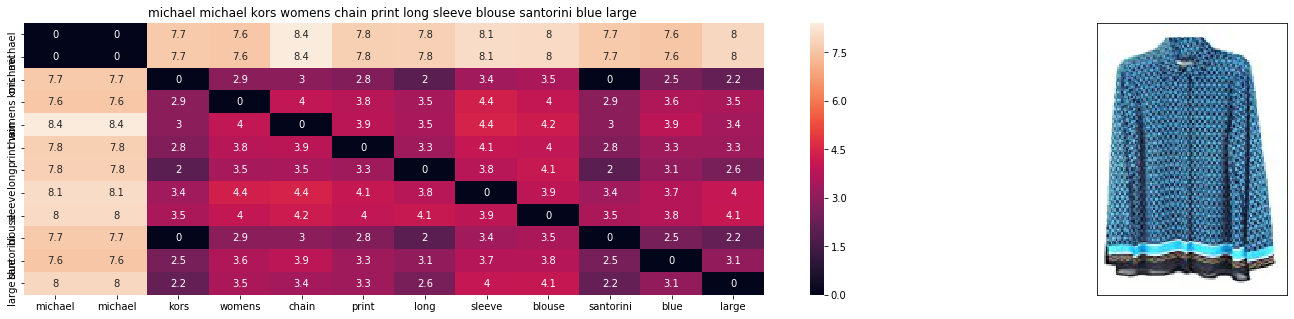

ASIN : B01FH19KVG
Brand : Michael Kors
euclidean distance from input : 9.5367431640625e-07


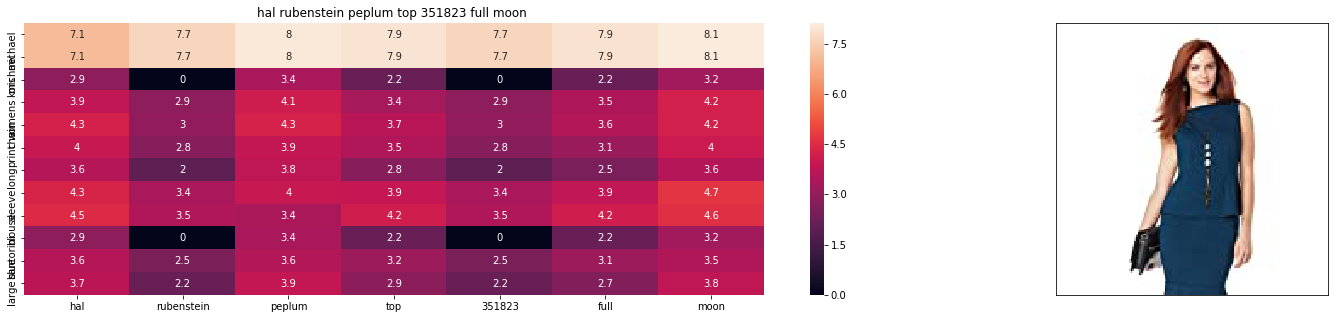

ASIN : B074LV9HMC
Brand : Hal Rubenstein
euclidean distance from input : 6.083007597923279


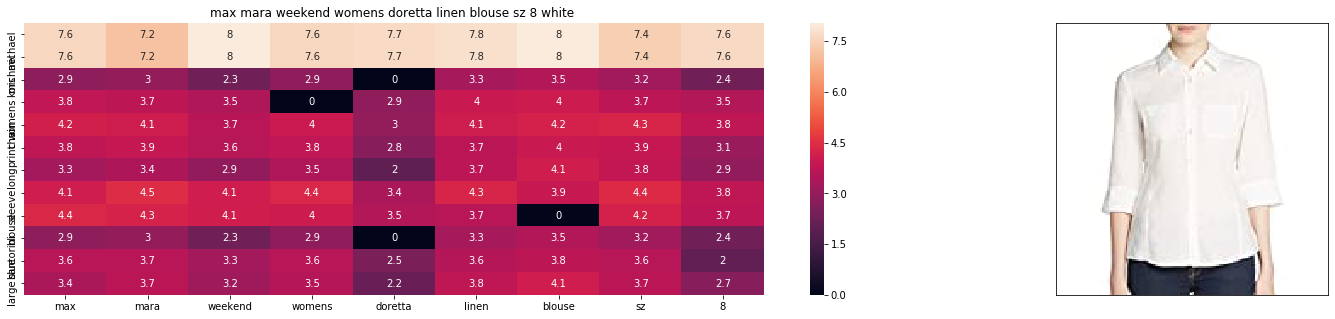

ASIN : B071NL8NML
Brand : MaxMara
euclidean distance from input : 6.747656459387213


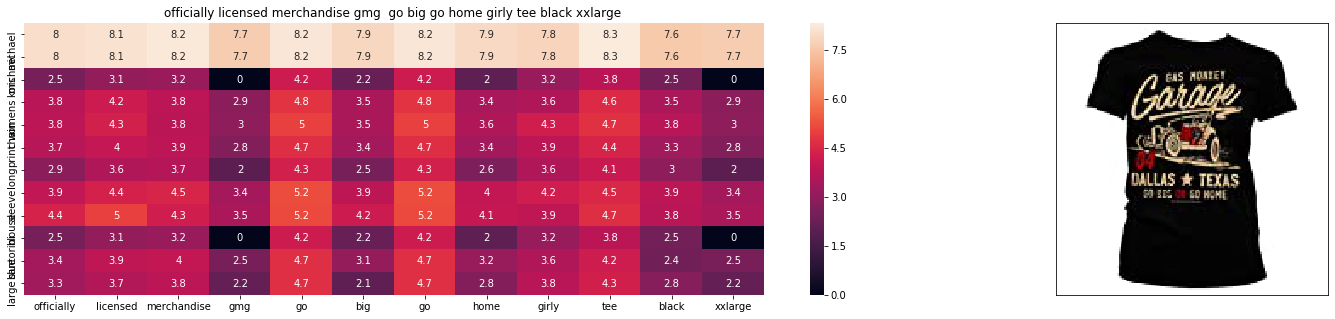

ASIN : B01KQIGTFK
Brand : Gas Monkey Garage
euclidean distance from input : 6.999620410492682


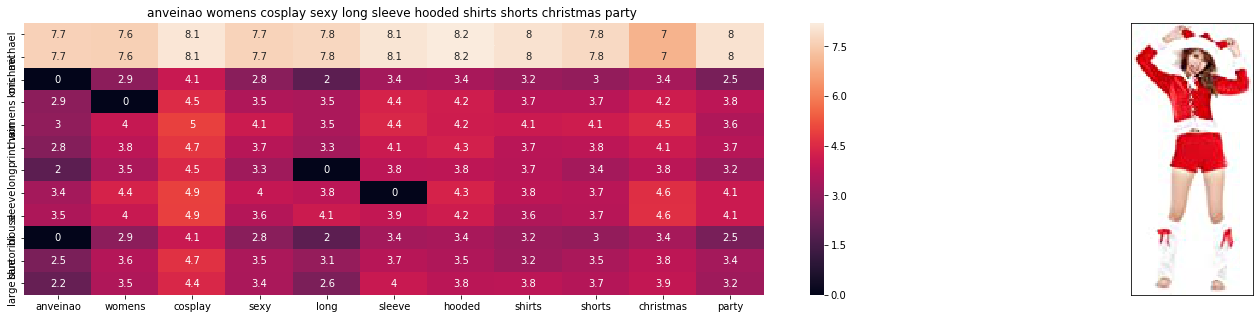

ASIN : B017RE9JTE
Brand : AnVei-Nao
euclidean distance from input : 7.001998894366331


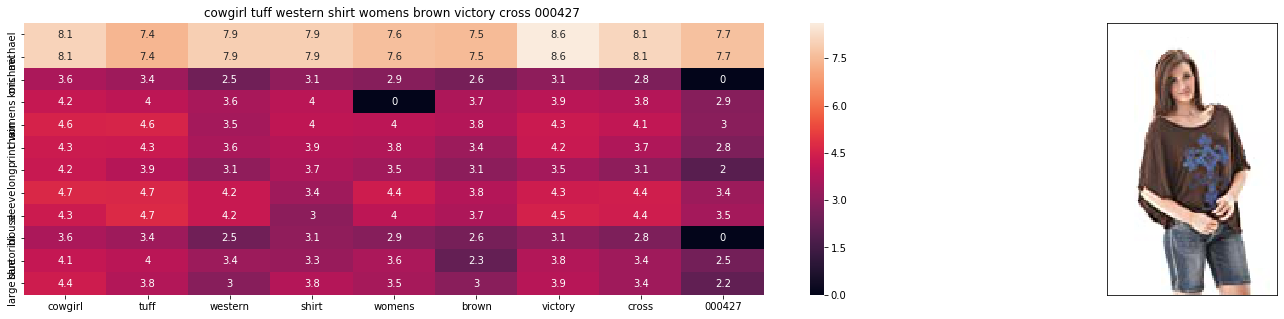

ASIN : B00YGHFIZA
Brand : Cowgirl Tuff
euclidean distance from input : 7.4507248093214695


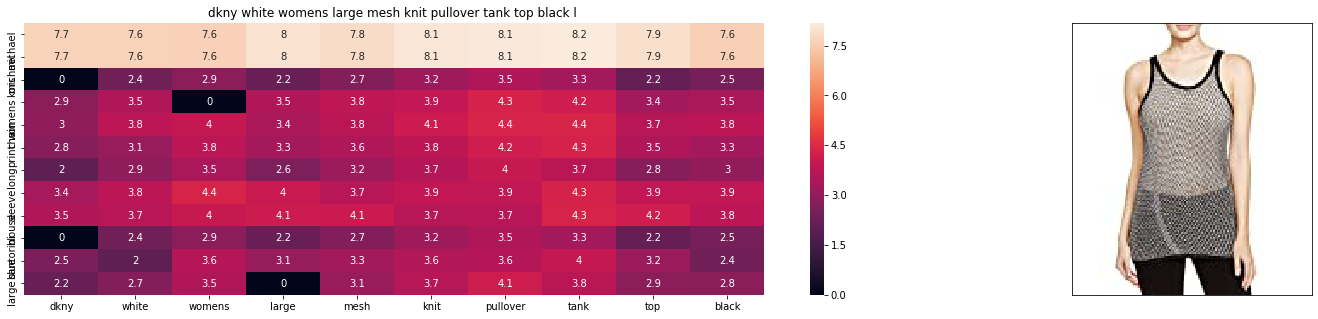

ASIN : B0716HXDT9
Brand : DKNY
euclidean distance from input : 7.527113718565374


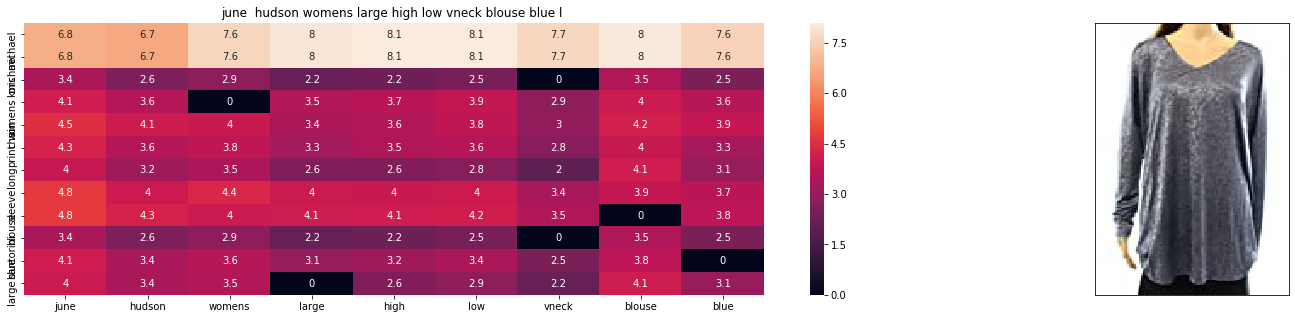

ASIN : B071P49QV7
Brand : Hudson & June
euclidean distance from input : 7.7362167000770565


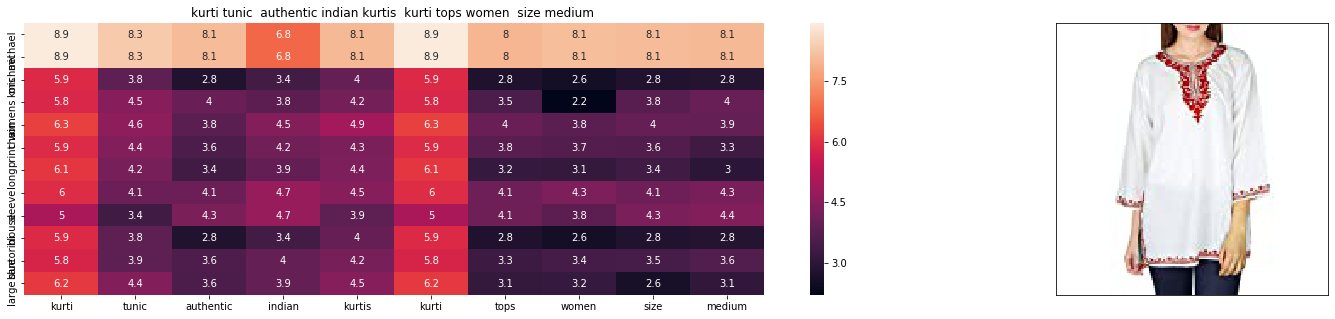

ASIN : B00L235QNA
Brand : ShalinIndia
euclidean distance from input : 8.439371771391302


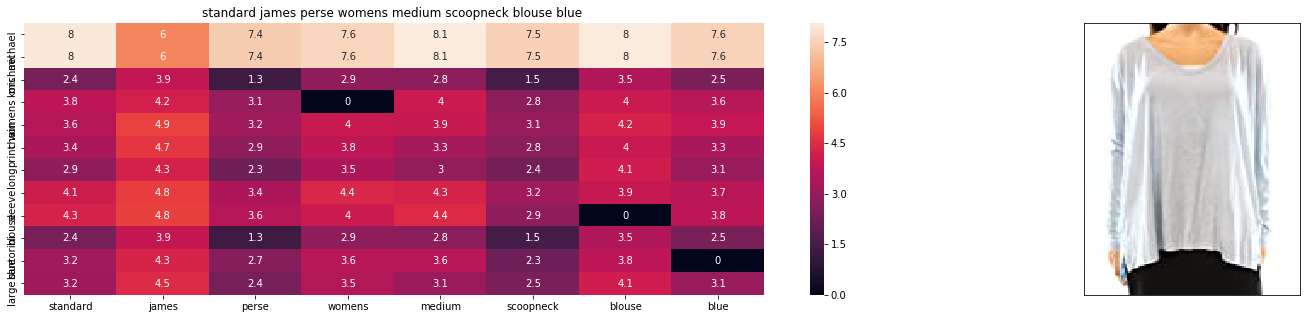

ASIN : B074PZHBD7
Brand : Standard James Perse
euclidean distance from input : 8.576145903009133


In [17]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_new_feat(doc_id, w1,w2,w3,w4,num_results):
    doc_id = asins.index(df_asins[doc_id])

    #pairwise distance for images feature
    img_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    #pairwise distance for  brand feature
    brand_feat_dist = pairwise_distances(brand_features, brand_features[doc_id])
    #pairwise distance for color feature
    color_feat_dist = pairwise_distances(color_features, color_features[doc_id])
    #pairwise distance for title feature
    title_idfw2v_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    #weighted pairwise distance
    pairwise_dist   = (w1*img_dist +  w2*brand_feat_dist +w3*color_feat_dist + w4*title_idfw2v_dist)/float(w1 + w2 + w3 +w4)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

get_similar_products_new_feat(12566, 5, 5,7,3, 10)


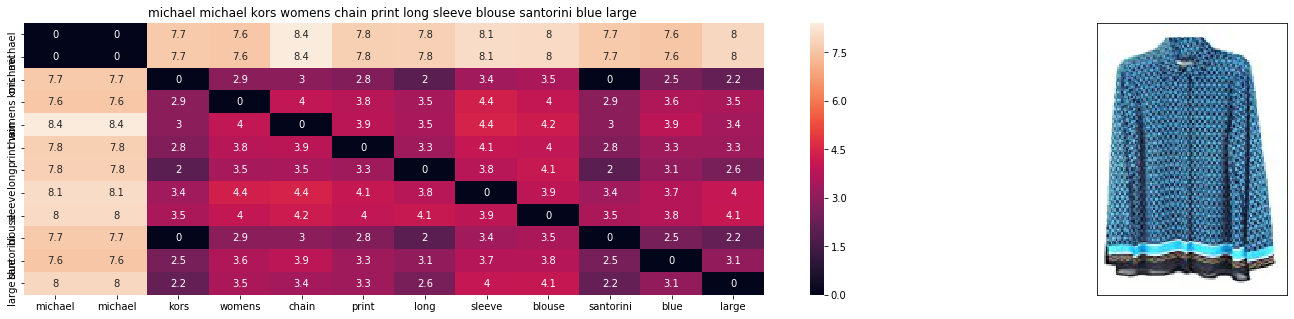

ASIN : B01FH19KVG
Brand : Michael Kors
euclidean distance from input : 2.0345052083333333e-06


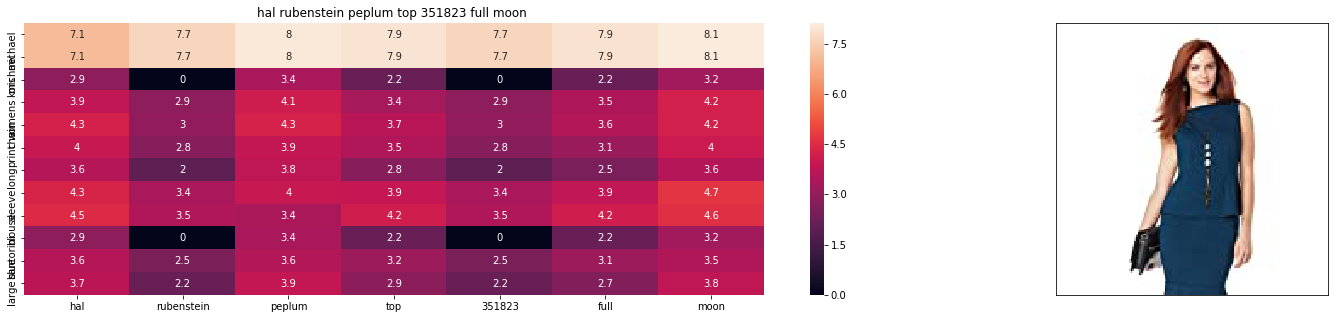

ASIN : B074LV9HMC
Brand : Hal Rubenstein
euclidean distance from input : 10.789350875218709


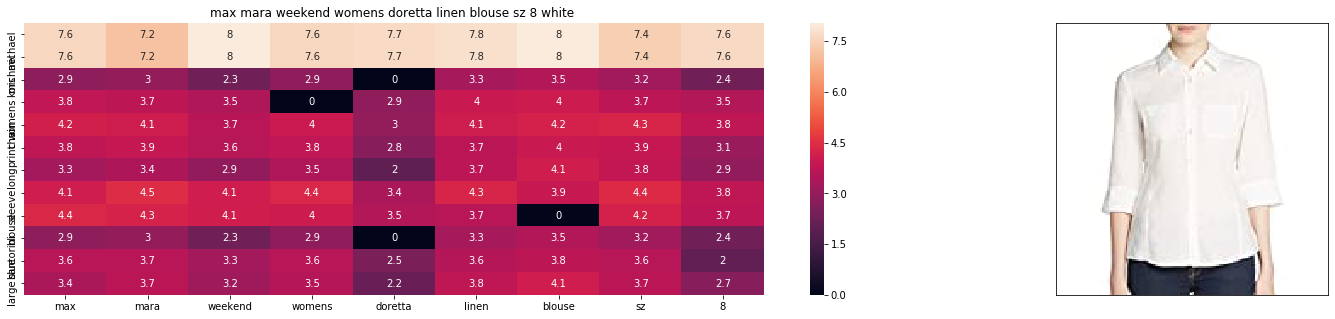

ASIN : B071NL8NML
Brand : MaxMara
euclidean distance from input : 12.510094343057425


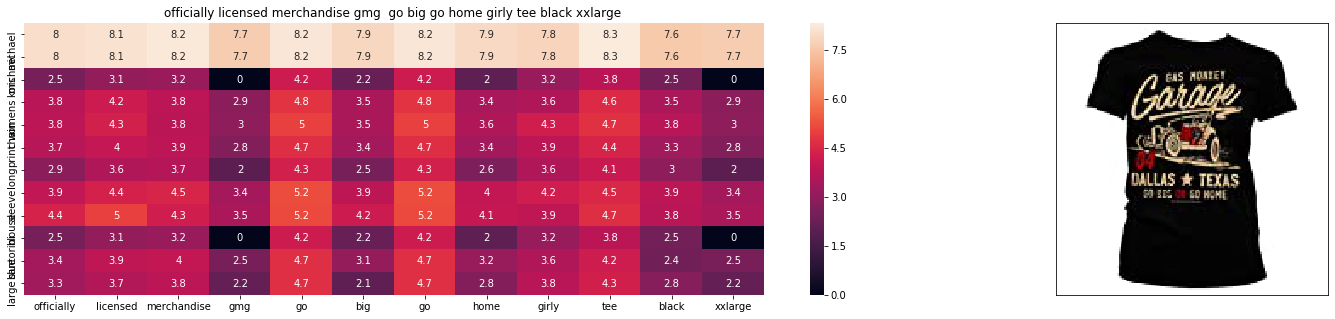

ASIN : B01KQIGTFK
Brand : Gas Monkey Garage
euclidean distance from input : 12.775052128088738


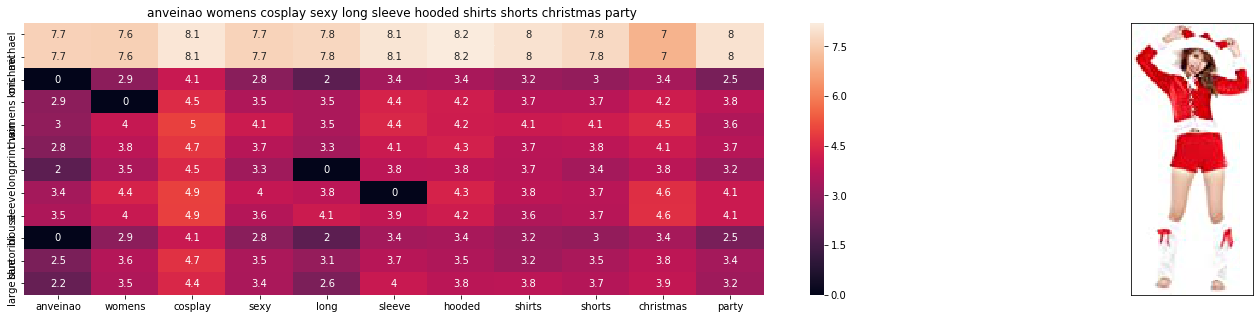

ASIN : B017RE9JTE
Brand : AnVei-Nao
euclidean distance from input : 12.923656747995505


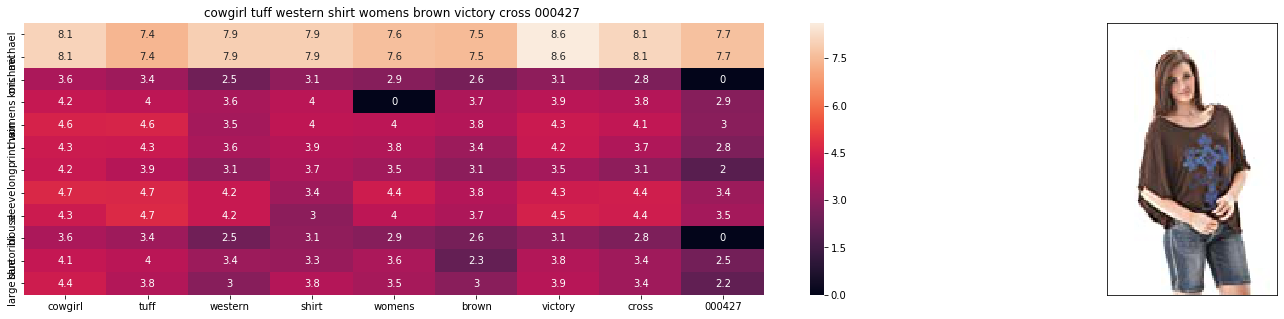

ASIN : B00YGHFIZA
Brand : Cowgirl Tuff
euclidean distance from input : 13.860124252496849


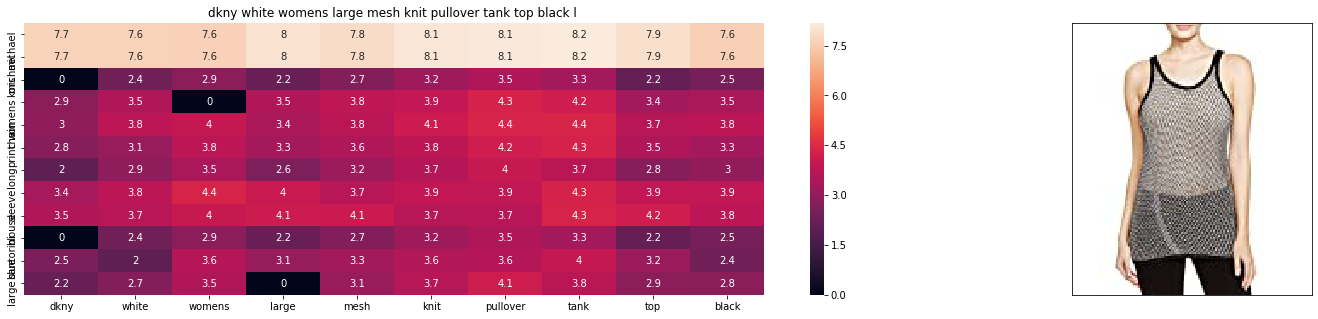

ASIN : B0716HXDT9
Brand : DKNY
euclidean distance from input : 14.14309245986854


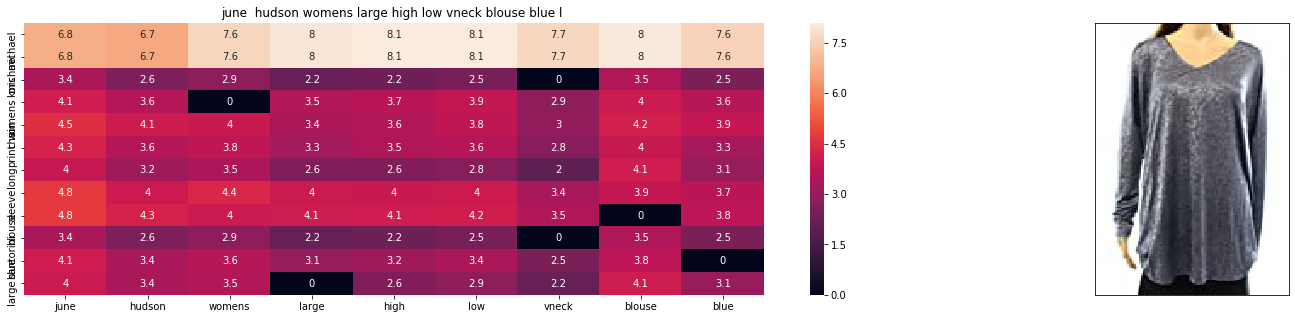

ASIN : B071P49QV7
Brand : Hudson & June
euclidean distance from input : 14.92155860265096


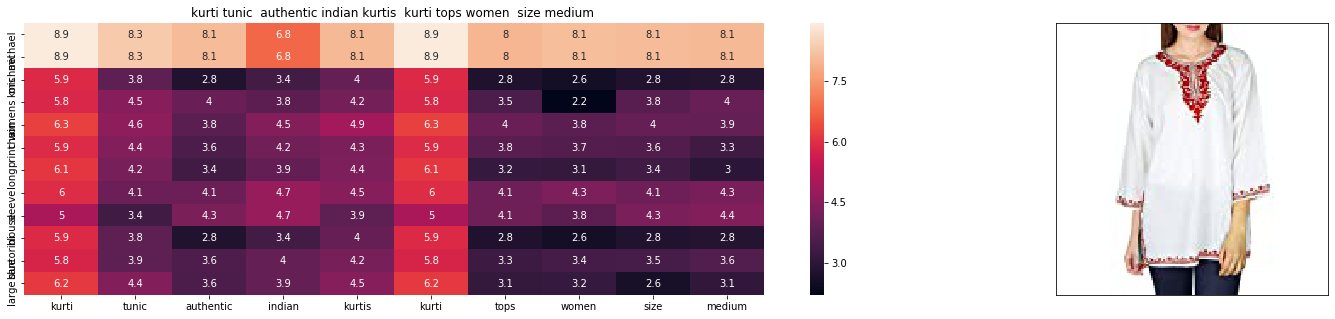

ASIN : B00L235QNA
Brand : ShalinIndia
euclidean distance from input : 15.979841647973807


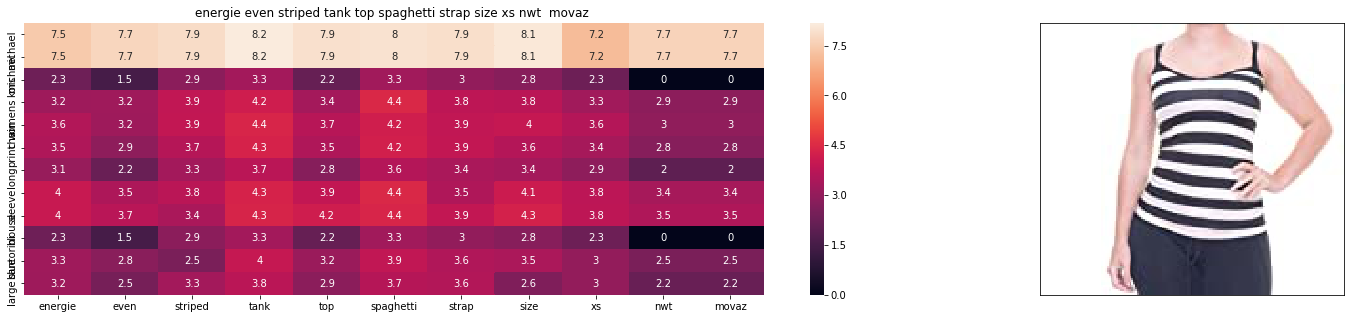

ASIN : B072JWQY1L
Brand : Energie
euclidean distance from input : 16.306158483199734


In [18]:
#giving more weight to image
get_similar_products_new_feat(12566,8,2,3,2, 10)

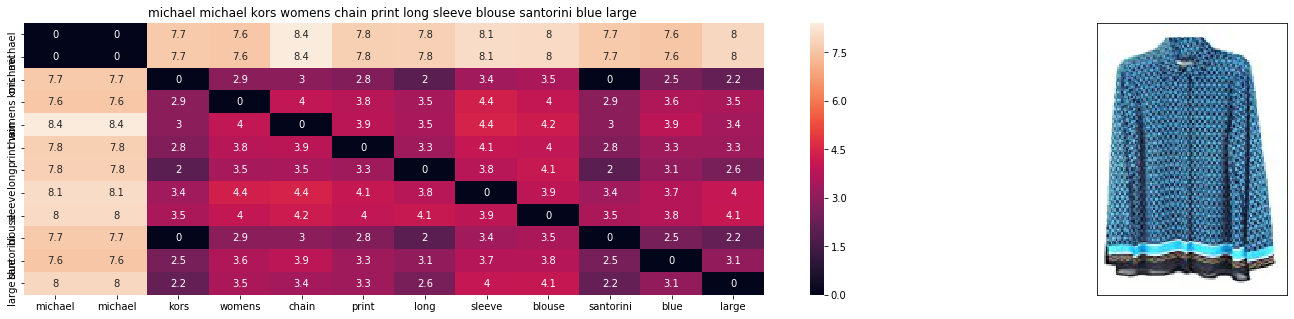

ASIN : B01FH19KVG
Brand : Michael Kors
euclidean distance from input : 4.238552517361111e-07


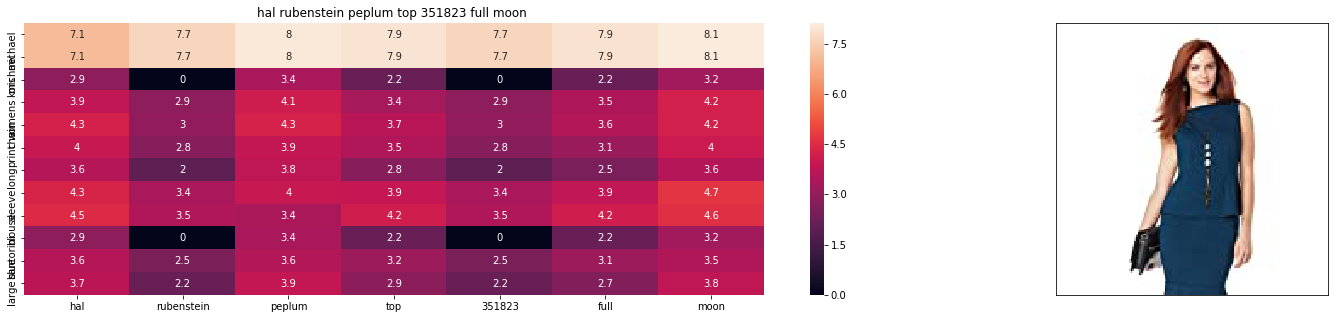

ASIN : B074LV9HMC
Brand : Hal Rubenstein
euclidean distance from input : 3.748891380098131


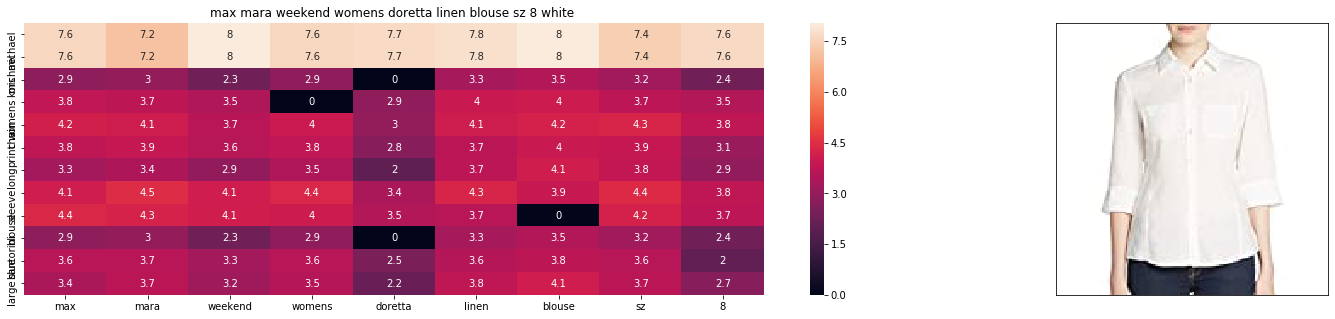

ASIN : B071NL8NML
Brand : MaxMara
euclidean distance from input : 3.896138635803229


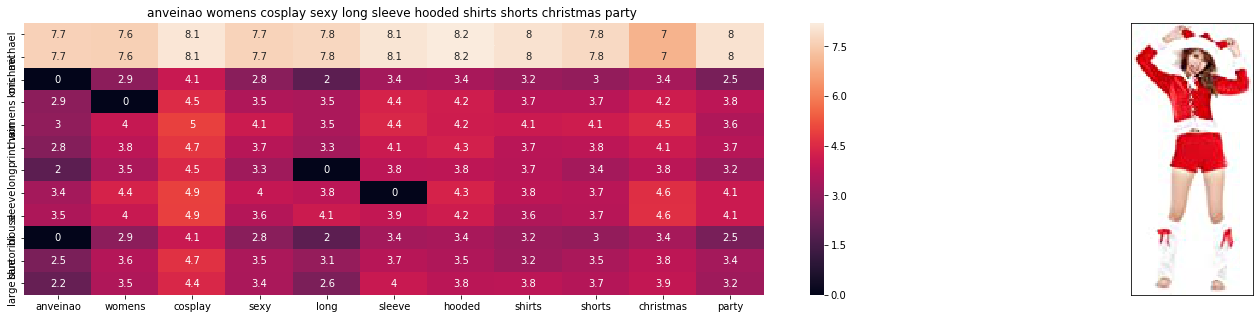

ASIN : B017RE9JTE
Brand : AnVei-Nao
euclidean distance from input : 4.131594351810457


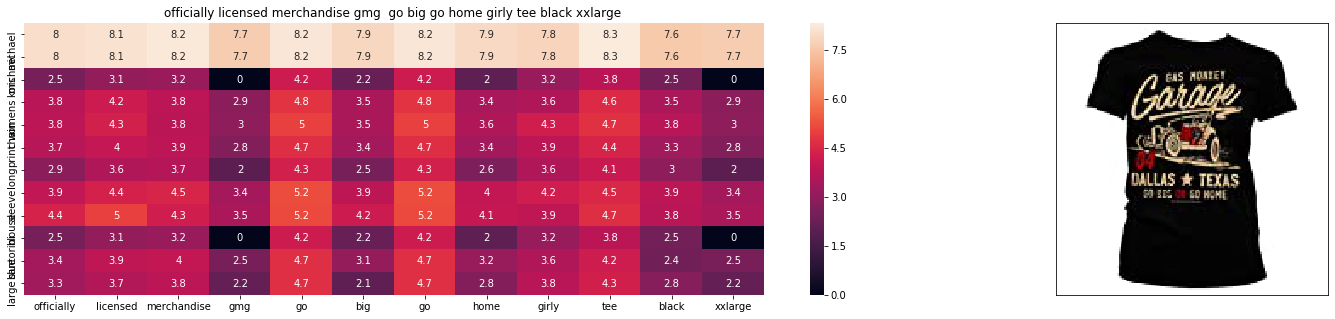

ASIN : B01KQIGTFK
Brand : Gas Monkey Garage
euclidean distance from input : 4.263260691058127


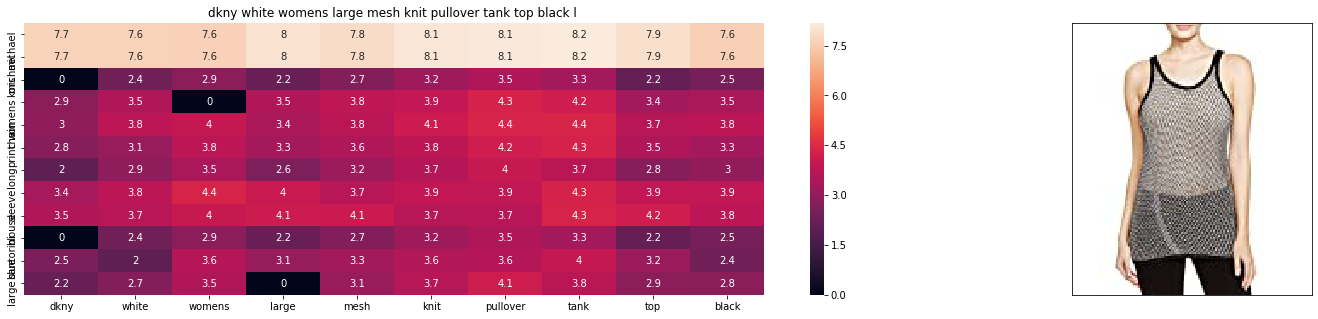

ASIN : B0716HXDT9
Brand : DKNY
euclidean distance from input : 4.267433875993523


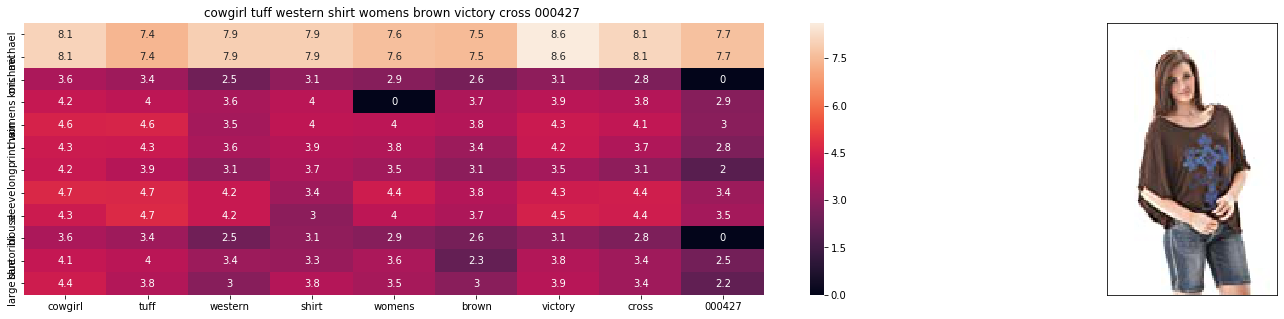

ASIN : B00YGHFIZA
Brand : Cowgirl Tuff
euclidean distance from input : 4.348373027525586


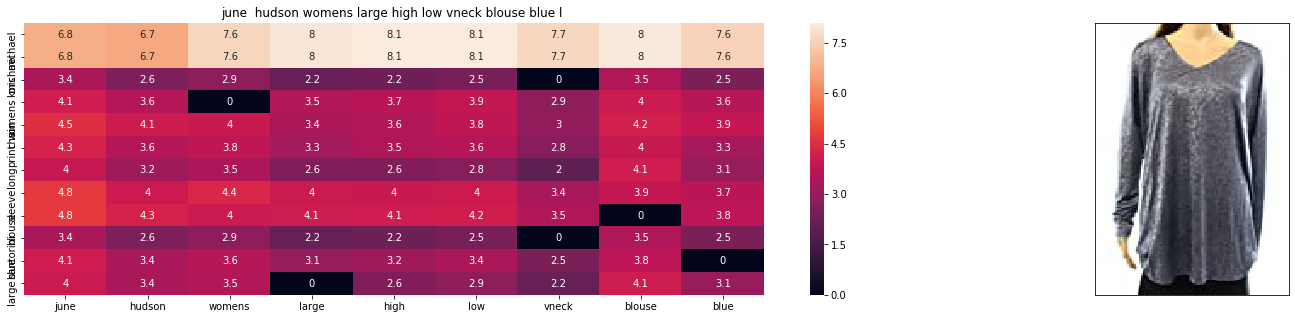

ASIN : B071P49QV7
Brand : Hudson & June
euclidean distance from input : 4.423626528845893


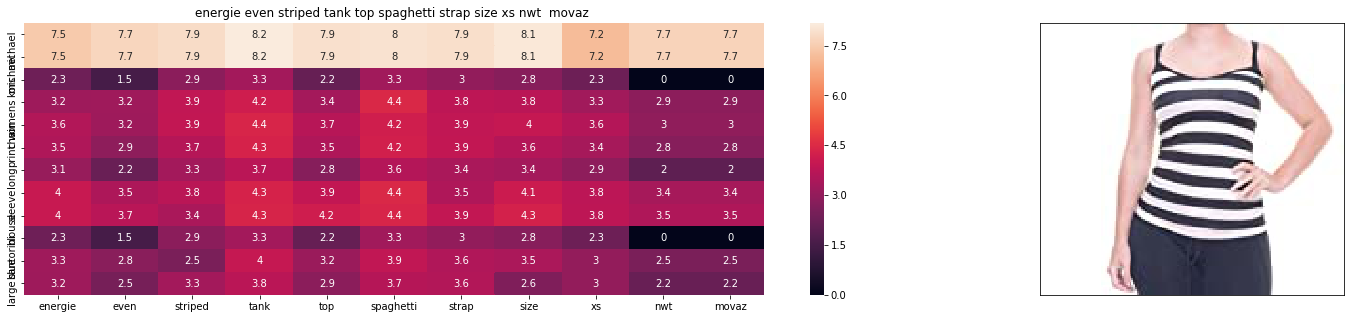

ASIN : B072JWQY1L
Brand : Energie
euclidean distance from input : 4.75181323519686


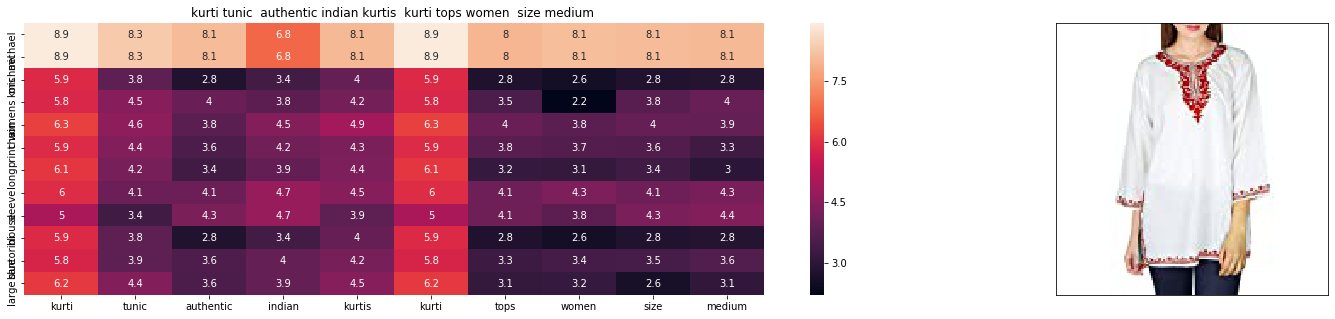

ASIN : B00L235QNA
Brand : ShalinIndia
euclidean distance from input : 4.764048835498392


In [19]:
#giving more weight to brand feature
get_similar_products_new_feat(12566,2,9,3,4, 10)

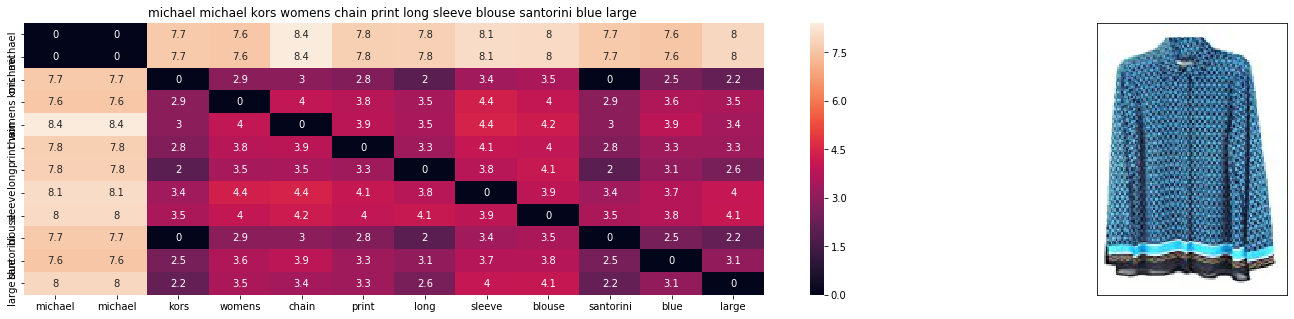

ASIN : B01FH19KVG
Brand : Michael Kors
euclidean distance from input : 2.724783761160714e-07


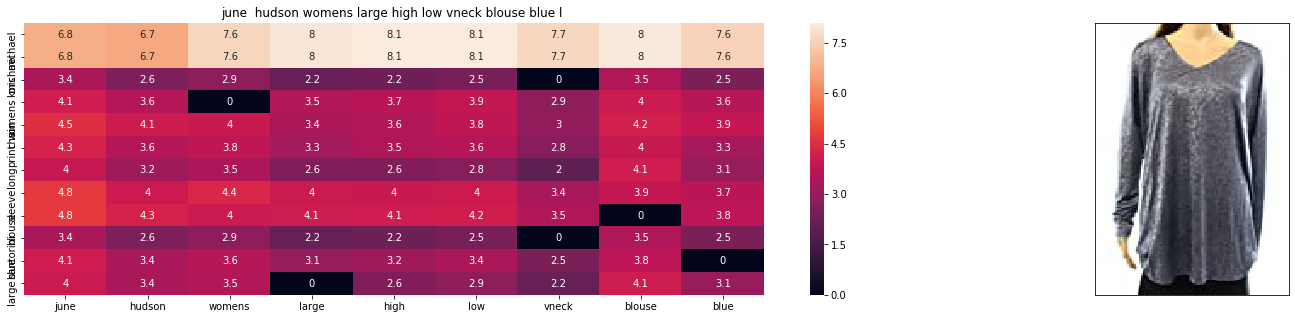

ASIN : B071P49QV7
Brand : Hudson & June
euclidean distance from input : 2.9509027685437883


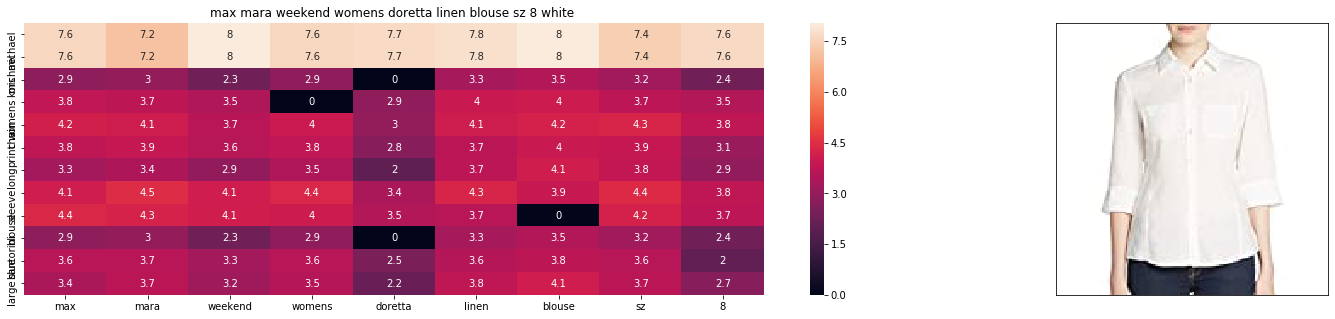

ASIN : B071NL8NML
Brand : MaxMara
euclidean distance from input : 3.1232501257195318


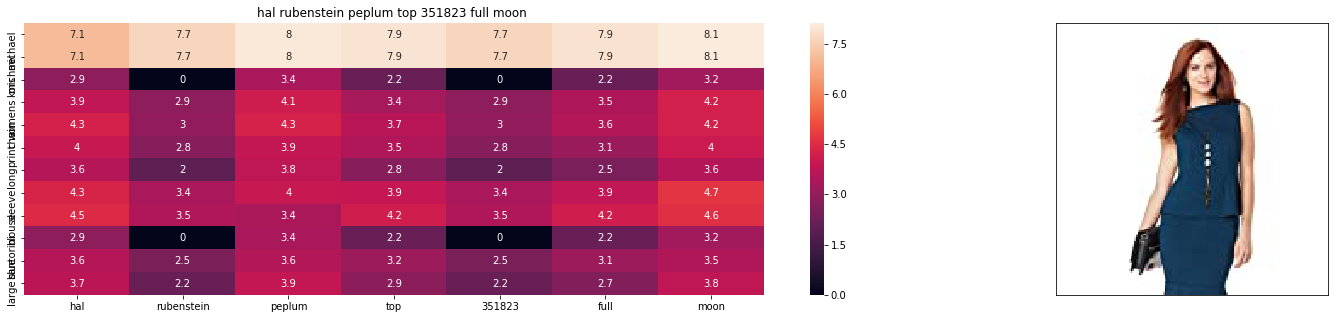

ASIN : B074LV9HMC
Brand : Hal Rubenstein
euclidean distance from input : 3.12428731577737


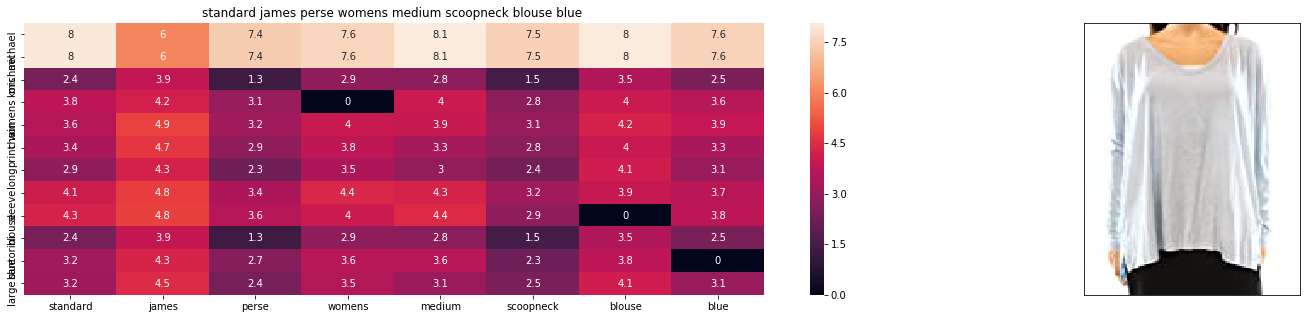

ASIN : B074PZHBD7
Brand : Standard James Perse
euclidean distance from input : 3.1835549705760693


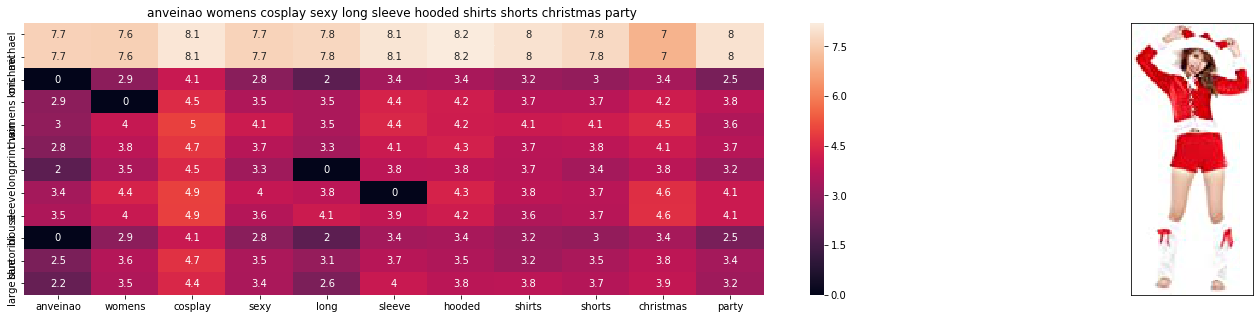

ASIN : B017RE9JTE
Brand : AnVei-Nao
euclidean distance from input : 3.2076272164735404


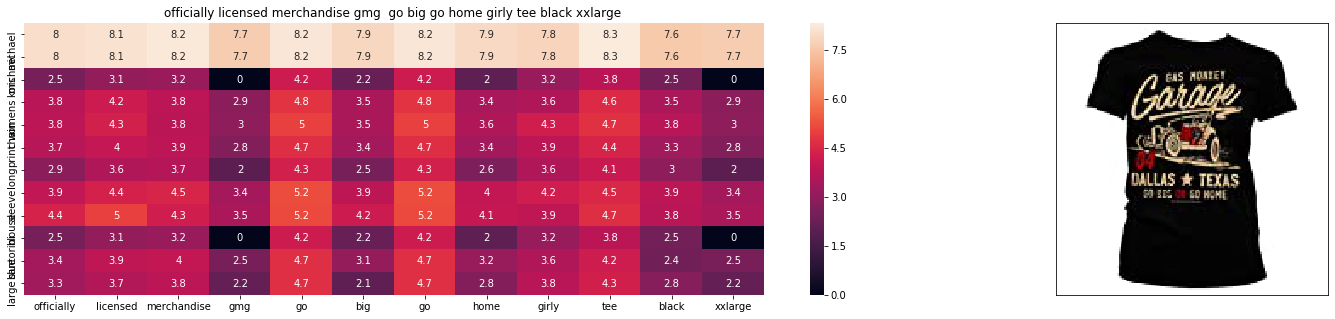

ASIN : B01KQIGTFK
Brand : Gas Monkey Garage
euclidean distance from input : 3.23325286875781


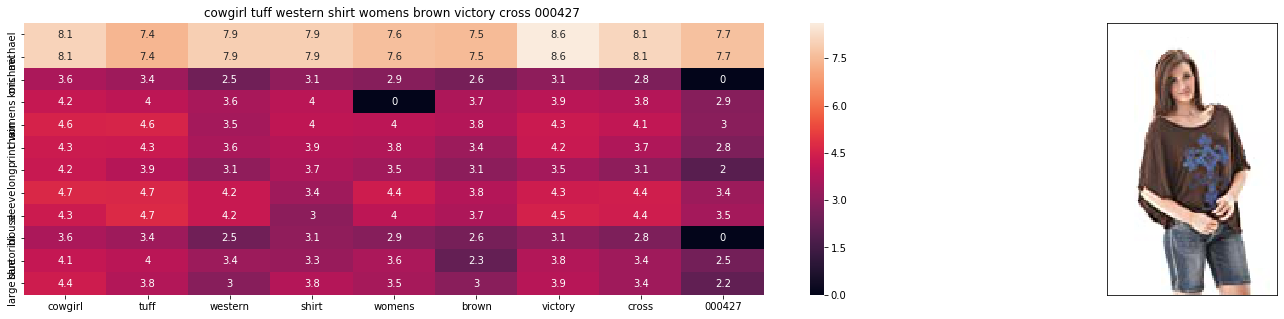

ASIN : B00YGHFIZA
Brand : Cowgirl Tuff
euclidean distance from input : 3.3469849365761233


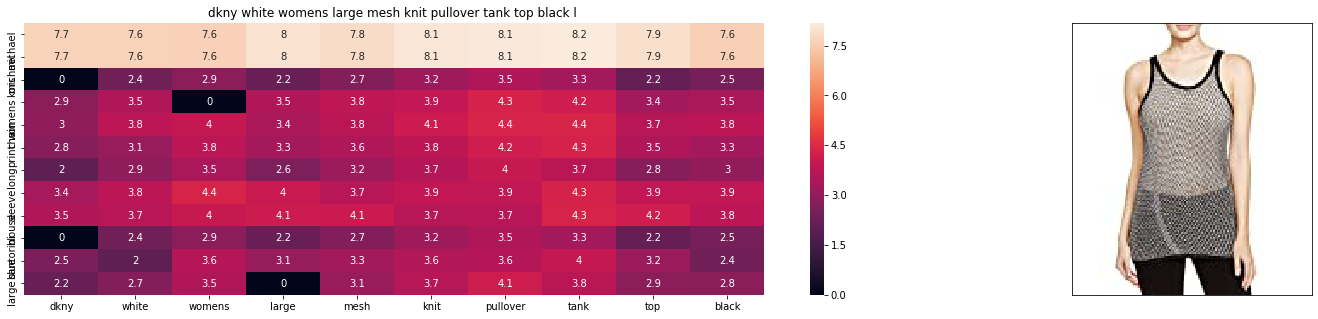

ASIN : B0716HXDT9
Brand : DKNY
euclidean distance from input : 3.3619399229847207


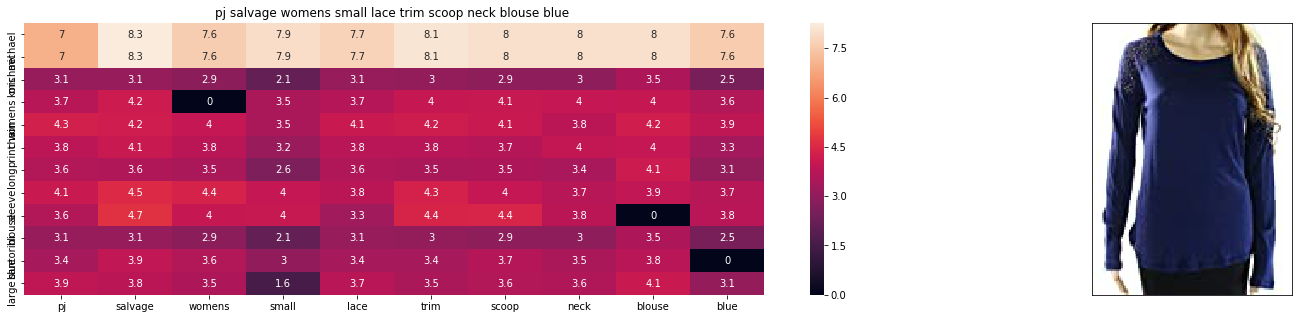

ASIN : B01N76LJ7H
Brand : PJ Salvage
euclidean distance from input : 3.6042984383446828


In [20]:
#giving more weight to color
get_similar_products_new_feat(12566,2,2,20,4, 10)

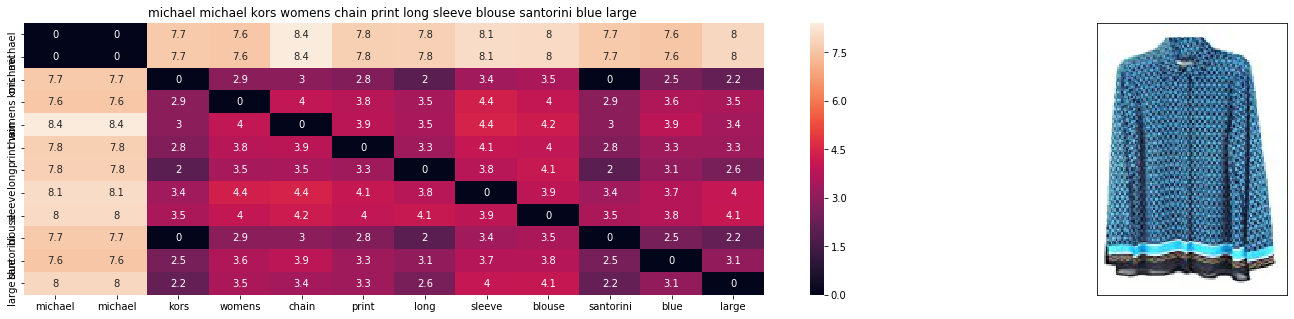

ASIN : B01FH19KVG
Brand : Michael Kors
euclidean distance from input : 4.4878791360294117e-07


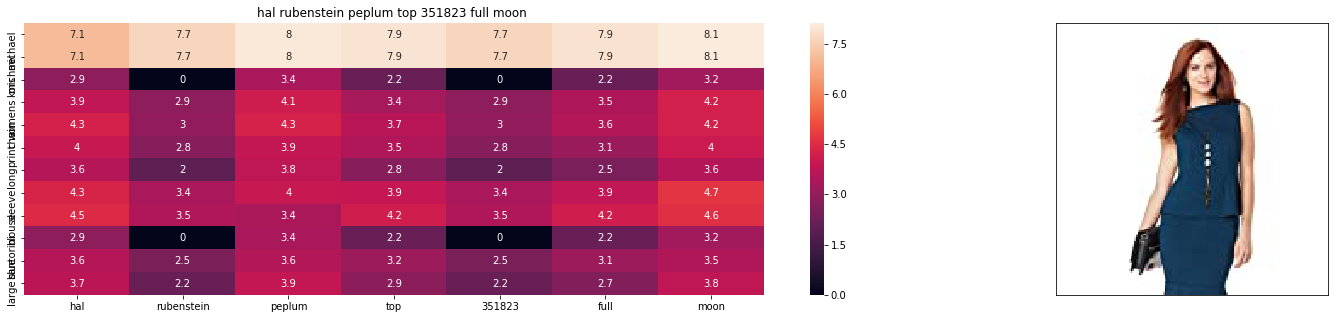

ASIN : B074LV9HMC
Brand : Hal Rubenstein
euclidean distance from input : 3.7025215485516716


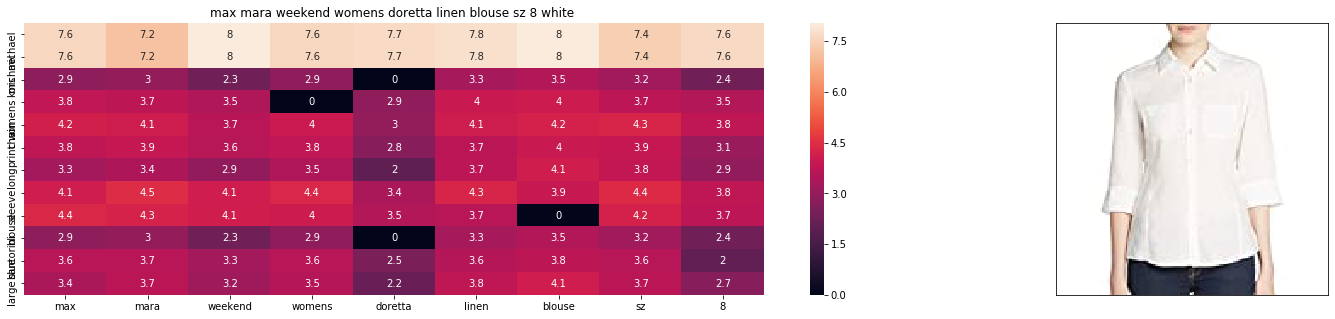

ASIN : B071NL8NML
Brand : MaxMara
euclidean distance from input : 3.8757993775528585


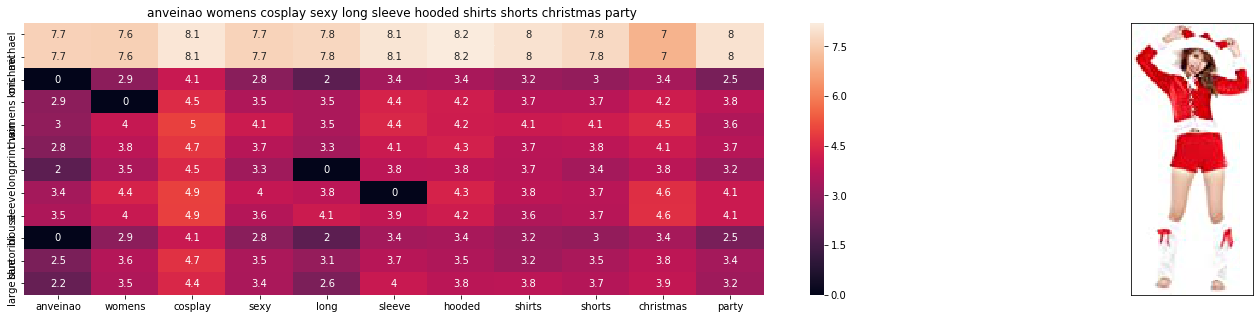

ASIN : B017RE9JTE
Brand : AnVei-Nao
euclidean distance from input : 4.056095332134024


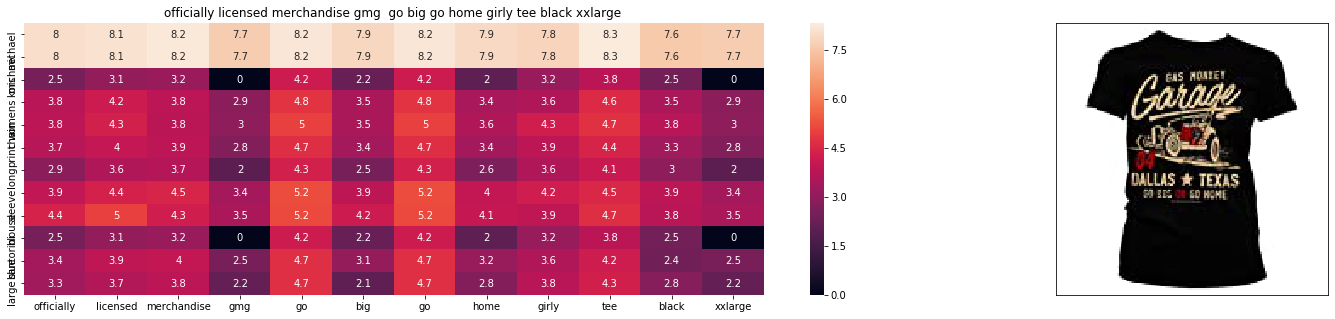

ASIN : B01KQIGTFK
Brand : Gas Monkey Garage
euclidean distance from input : 4.1911443347898185


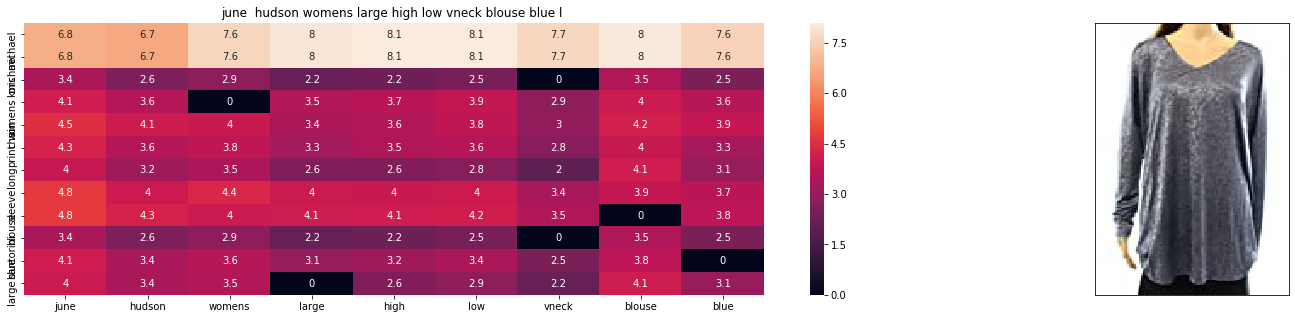

ASIN : B071P49QV7
Brand : Hudson & June
euclidean distance from input : 4.305967555326574


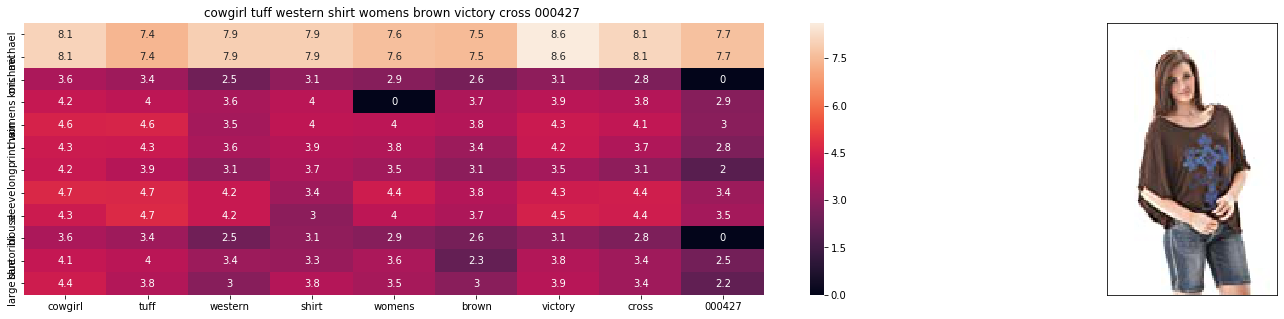

ASIN : B00YGHFIZA
Brand : Cowgirl Tuff
euclidean distance from input : 4.324979934849011


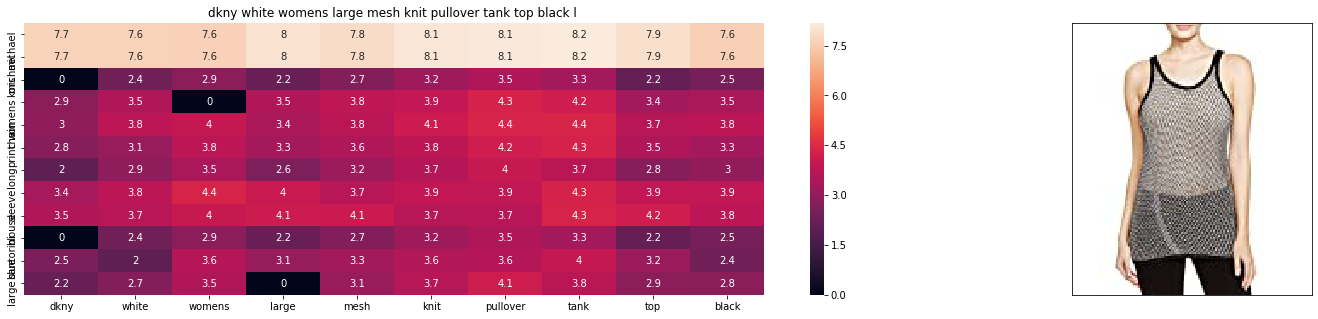

ASIN : B0716HXDT9
Brand : DKNY
euclidean distance from input : 4.325362852768995


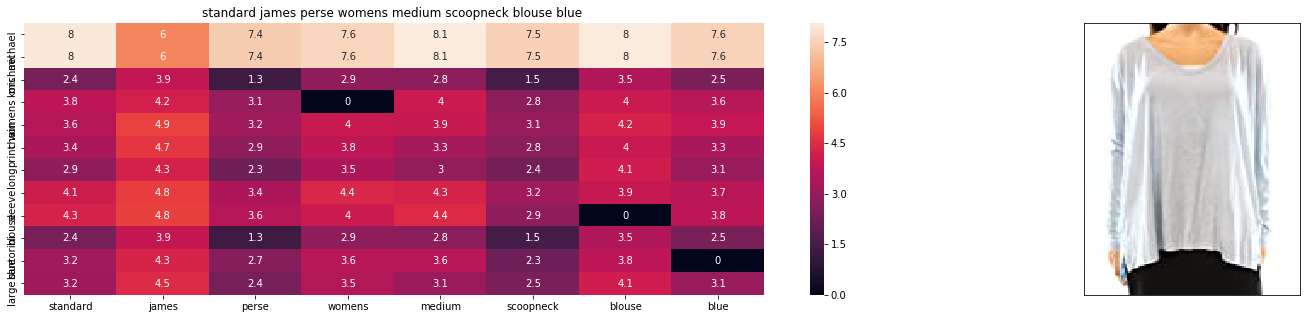

ASIN : B074PZHBD7
Brand : Standard James Perse
euclidean distance from input : 4.6632971164001935


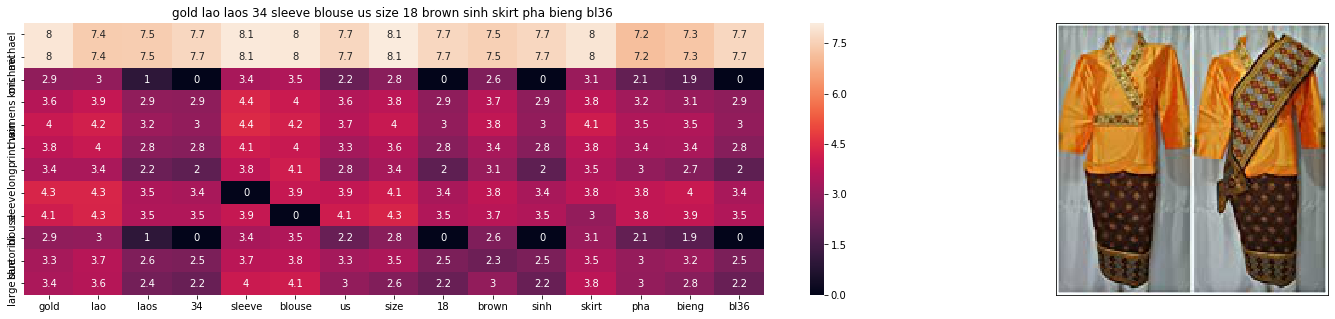

ASIN : B073XF6KSD
Brand : Mukdahan Craft
euclidean distance from input : 4.831350254888648


In [21]:
#giving more weight to title
get_similar_products_new_feat(12566,2,2,3,10, 10)

# Conclusion

Used Text, brand, color and image features to recommend similar products.

Given weights feature for all the features one by one keeping one weight hogh and others moderate to see how image recommendations vary based on features.

This simple recommendation model using euclidean distance as the measure gave some satisfying recommendation